---   
# HW3 - Transfer learning

#### Due October 30, 2019

In this assignment you will learn about transfer learning. This technique is perhaps one of the most important techniques for industry. When a problem you want to solve does not have enough data, we use a different (larger) dataset to learn representations which can help us solve our task using the smaller task.

The general steps to transfer learning are as follows:

1. Find a huge dataset with similar characteristics to the problem you are interested in.
2. Choose a model powerful enough to extract meaningful representations from the huge dataset.
3. Train this model on the huge dataset.
4. Use this model to train on the smaller dataset.


### This homework has the following sections:
1. Question 1: MNIST fine-tuning (Parts A, B, C, D).
2. Question 2: Pretrain on Wikitext2 (Part A, B, C, D)
3. Question 3: Finetune on MNLI (Part A, B, C, D)
4. Question 4: Finetune using pretrained BERT (Part A, B, C)

---   
## Question 1 (MNIST transfer learning)
To grasp the high-level approach to transfer learning, let's first do a simple example using computer vision. 

The torchvision library has pretrained models (resnets, vggnets, etc) on the Imagenet dataset. Imagenet is a dataset
with 1.3 million images covering over 1000 classes of objects. When you use one of these models, the weights of the model initialize
with the weights saved from training on imagenet.

In this task we will:
1. Choose a pretrained model.
2. Freeze the model so that the weights don't change.
3. Fine-tune on a few labels of MNIST.   

#### Choose a model
Here we pick any of the models from torchvision

In [0]:
import torch
import torchvision.models as models

class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# init the pretrained feature extractor
pretrained_resnet18 = models.resnet18(pretrained=True)
#pretrained_resnet18
# we don't want the built in last layer, we're going to modify it ourselves
#pretrained_resnet18.fc = Identity()

In [20]:
pretrained_resnet18.fc = Identity()
pretrained_resnet18.fc

Identity()

In [0]:
#pretrained_resnet18

#### Freeze the model
Here we freeze the weights of the model. Freezing means the gradients will not backpropagate
into these weights.

By doing this you can think about the model as a feature extractor. This feature extractor outputs
a **representation** of an input. This representation is a matrix that encodes information about the input.

In [0]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True
        
freeze_model(pretrained_resnet18)

#### Init target dataset
Here we define the dataset we are actually interested in.

In [0]:
import os
from torchvision import transforms
from torchvision.datasets import  MNIST
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

#  train/val  split
transform = transforms.Compose([transforms.Grayscale(3),
    transforms.ToTensor()
])
mnist_dataset = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_train, mnist_val = random_split(mnist_dataset, [55000, 5000])

mnist_train = DataLoader(mnist_train, batch_size=32)
mnist_val = DataLoader(mnist_val, batch_size=32)

# test split
mnist_test = DataLoader(MNIST(os.getcwd(), train=False, download=True, transform=transform), batch_size=32)

In [24]:
for images, labels in mnist_train:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 28, 28])
Image label dimensions: torch.Size([32])


### Part A (init fine-tune model)
decide what model to use for fine-tuning

In [0]:
from torch import nn
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [0]:
def init_fine_tune_model():
    
    # YOUR CODE HERE
    
    fine_tune_model = Net(512,256,10)
    return fine_tune_model
  
  
#fine_tune_model = init_fine_tune_model()

### Part B (Fine-tune (Frozen))

The actual problem we care about solving likely has a different number of classes or is a different task altogether. Fine-tuning is the process of using the extracted representations (features) to solve this downstream task  (the task you're interested in).

To illustrate this, we'll use our pretrained model (on Imagenet), to solve the MNIST classification task.

There are two types of finetuning. 

#### 1. Frozen feature_extractor
In the first type we pretrain with the FROZEN feature_extractor and NEVER unfreeze it during finetuning.


#### 2. Unfrozen feature_extractor
In the second, we finetune with a FROZEN feature_extractor for a few epochs, then unfreeze the feature extractor and finish training.


In this part we will use the first version

In [0]:
import numpy as np

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, unfrozen,patience=5, verbose=False, delta=0,name = 'RNN_'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.name = name
        self.unfrozen = unfrozen

    def __call__(self, val_loss, model, extractor):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, extractor)
        elif score < self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, extractor)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, extractor):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.name+'checkpoint.pt')
        if self.unfrozen:
          torch.save(extractor.state_dict(), self.name+'extractor_checkpoint.pt')
        self.val_loss_min = val_loss
        
patience = 5
early_stopping = EarlyStopping(unfrozen=False,patience=patience, verbose=True,name="MLP_frozen_")


In [0]:
import torch.optim as optim
plot_cache = []
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

def FROZEN_fine_tune_mnist(feature_extractor, fine_tune_model, mnist_train, mnist_val,num_epochs=10,patience=5):
    """
    model is a feature extractor (resnet).
    Create a new model which uses those features to finetune on MNIST
    
    return the fine_tune model
    """     
    
    # INSERT YOUR CODE: (train the fine_tune model using features extracted by feature_extractor)
    for epoch_number in range(num_epochs):
        avg_loss=0
        fine_tune_model.train()
        feature_extractor.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(mnist_train):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            inp = feature_extractor(inp)
            logits = fine_tune_model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
        #do valid
        valid_losses = []
        fine_tune_model.eval()
        feature_extractor.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(mnist_val):
                inp = inp.to(current_device)
                target = target.to(current_device)
                inp = feature_extractor(inp)
                logits = fine_tune_model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
        plot_cache.append((avg_loss, avg_val_loss))
    
        early_stopping(avg_val_loss, fine_tune_model,feature_extractor)
        torch.save({
        'loss_cache': plot_cache
        }, './fine_tune_model_frozen.pt')
    
    
        if early_stopping.early_stop:
            print("Early stopping")
            break
    

In [0]:
fine_tune_model = init_fine_tune_model()
fine_tune_model.to(current_device)
feature_extractor = pretrained_resnet18.to(current_device)
criterion = nn.CrossEntropyLoss()
fine_tune_model_parameters = list(feature_extractor.parameters()) + list(fine_tune_model.parameters())
optimizer = optim.Adam(filter(lambda p: p.requires_grad, fine_tune_model_parameters))
#optimizer = optim.Adam(fine_tune_model_parameters)

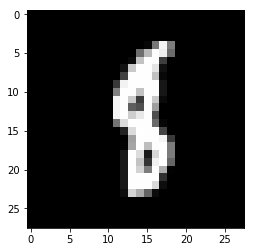

In [30]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(images[11],(1,2,0)))

### Part C (compute test accuracy)
Compute the test accuracy of fine-tuned model on MNIST

In [0]:
def calculate_mnist_test_accuracy(feature_extractor, fine_tune_model, mnist_test):
    
    # YOUR CODE HERE...

    feature_extractor.eval()
    fine_tune_model.eval()
    total = 0
    correct = 0
    for inp,target in mnist_test:
      inp = inp.to(current_device)
      target = target.to(current_device)
      inp = feature_extractor(inp)
      logits = fine_tune_model(inp)
      outputs = F.softmax(logits, dim=1)
      predicted = outputs.max(1, keepdim=True)[1]
      temp = predicted
      total += target.size(0)
      correct += predicted.eq(target.view_as(predicted).to(current_device)).sum().item()
    return (100 * correct / total)
    
    

In [32]:
 calculate_mnist_test_accuracy(feature_extractor, fine_tune_model, mnist_test)

12.12

### Grade!
Let's see how you did

In [33]:
def grade_mnist_frozen(load_pretrained):
    
    # init a ft model
    #fine_tune_model = init_fine_tune_model().to(current_device)
    
    # run the transfer learning routine
    if not load_pretrained:
      FROZEN_fine_tune_mnist(feature_extractor, fine_tune_model, mnist_train, mnist_val,num_epochs=10,patience=5)
    
    frozen_model = init_fine_tune_model()
    frozen_model.load_state_dict(torch.load("MLP_frozen_checkpoint.pt"))
    frozen_model.to(current_device)
    # calculate test accuracy
    test_accuracy = calculate_mnist_test_accuracy(feature_extractor, frozen_model, mnist_test)
    
    # the real threshold will be released by Oct 11 
    assert test_accuracy > 0.0, 'your accuracy is too low...'
    
    return test_accuracy
    
frozen_test_accuracy = grade_mnist_frozen(load_pretrained=False)

Step 0 avg train loss = 2.3100
Step 100 avg train loss = 1.5123
Step 200 avg train loss = 1.1640
Step 300 avg train loss = 1.0463
Step 400 avg train loss = 0.9684
Step 500 avg train loss = 0.9852
Step 600 avg train loss = 0.9466
Step 700 avg train loss = 0.9531
Step 800 avg train loss = 0.9319
Step 900 avg train loss = 0.8971
Step 1000 avg train loss = 0.8928
Step 1100 avg train loss = 0.8837
Step 1200 avg train loss = 0.8593
Step 1300 avg train loss = 0.8264
Step 1400 avg train loss = 0.8586
Step 1500 avg train loss = 0.8186
Step 1600 avg train loss = 0.8034
Step 1700 avg train loss = 0.8276
Validation loss after 0 epoch = 0.7022
Validation loss decreased (inf --> 0.702193).  Saving model ...
Step 0 avg train loss = 1.0094
Step 100 avg train loss = 0.7951
Step 200 avg train loss = 0.8024
Step 300 avg train loss = 0.7844
Step 400 avg train loss = 0.7438
Step 500 avg train loss = 0.7734
Step 600 avg train loss = 0.7532
Step 700 avg train loss = 0.7785
Step 800 avg train loss = 0.7567
St

In [35]:
print(frozen_test_accuracy)

78.75


### Part D (Fine-tune Unfrozen)
Now we'll learn how to train using the "unfrozen" approach.

In this approach we'll:
1. keep the feature_extract frozen for a few epochs (10)
2. Unfreeze it.
3. Finish training

In [0]:
patience = 5
early_stopping_unfrozen = EarlyStopping(unfrozen=True,patience=patience, verbose=True,name="MLP_unfrozen_")

In [0]:
def UNFROZEN_fine_tune_mnist(feature_extractor, fine_tune_model, mnist_train, mnist_val,num_epochs=50,patience=5):
    """
    model is a feature extractor (resnet).
    Create a new model which uses those features to finetune on MNIST
    
    return the fine_tune model
    """     
    
    # INSERT YOUR CODE:
    # keep frozen for 10 epochs
    # ... train
    # unfreeze
    # train for rest of the time
    criterion_unfrozen = nn.CrossEntropyLoss()
    fine_tune_model_parameters_unfrozen = list(feature_extractor.parameters()) + list(fine_tune_model.parameters())
    optimizer_unfrozen = optim.Adam(filter(lambda p: p.requires_grad, fine_tune_model_parameters_unfrozen))
    for epoch_number in range(10):
        avg_loss=0
        fine_tune_model.train()
        feature_extractor.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(mnist_train):
            optimizer_unfrozen.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            inp = feature_extractor(inp)
            logits = fine_tune_model(inp)
            
            loss = criterion_unfrozen(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer_unfrozen.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
        #do valid
        valid_losses = []
        fine_tune_model.eval()
        feature_extractor.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(mnist_val):
                inp = inp.to(current_device)
                target = target.to(current_device)
                inp = feature_extractor(inp)
                logits = fine_tune_model(inp)

                loss = criterion_unfrozen(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
        plot_cache.append((avg_loss, avg_val_loss))
    
    unfreeze_model(feature_extractor)
    fine_tune_model_parameters_unfrozen2 = list(feature_extractor.parameters()) + list(fine_tune_model.parameters())
    optimizer_unfrozen2 = optim.Adam(filter(lambda p: p.requires_grad, fine_tune_model_parameters_unfrozen2))
    
    
    for epoch_number in range(num_epochs):
        avg_loss=0
        fine_tune_model.train()
        feature_extractor.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(mnist_train):
            optimizer_unfrozen2.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            inp = feature_extractor(inp)
            logits = fine_tune_model(inp)
            
            loss = criterion_unfrozen(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer_unfrozen2.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
        #do valid
        valid_losses = []
        fine_tune_model.eval()
        feature_extractor.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(mnist_val):
                inp = inp.to(current_device)
                target = target.to(current_device)
                inp = feature_extractor(inp)
                logits = fine_tune_model(inp)

                loss = criterion_unfrozen(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
        plot_cache.append((avg_loss, avg_val_loss))
                
        early_stopping_unfrozen(avg_val_loss, fine_tune_model,feature_extractor)
        torch.save({
            'loss_cache': plot_cache
        }, './fine_tune_model_unfrozen.pt')
    
    
        if early_stopping_unfrozen.early_stop:
            print("Early stopping")
            break
    
    
    
    
    
    

### Grade UNFROZEN
Let's see if there's a difference in accuracy!

In [0]:
fine_tune_model_unfrozen = init_fine_tune_model()
fine_tune_model_unfrozen.to(current_device)
feature_extractor_unfrozen = pretrained_resnet18.to(current_device)

In [39]:
def grade_mnist_unfrozen(load_pretrained):
    
    # init a ft model
    #fine_tune_model = init_fine_tune_model()
    
    # run the transfer learning routine
    if not load_pretrained:
      UNFROZEN_fine_tune_mnist(feature_extractor_unfrozen,fine_tune_model_unfrozen, mnist_train, mnist_val,num_epochs=20,patience=5)
    
    # calculate test accuracy
    feature_extractor_unfrozen_test = models.resnet18(pretrained=False)
    feature_extractor_unfrozen_test.fc = Identity()
    feature_extractor_unfrozen_test.load_state_dict(torch.load("MLP_unfrozen_extractor_checkpoint.pt"))
    feature_extractor_unfrozen_test.to(current_device)
    
    fine_tune_model_unfrozen_test = init_fine_tune_model()
    fine_tune_model_unfrozen_test.load_state_dict(torch.load("MLP_unfrozen_checkpoint.pt"))
    fine_tune_model_unfrozen_test.to(current_device)
    test_accuracy = calculate_mnist_test_accuracy(feature_extractor_unfrozen_test, fine_tune_model_unfrozen_test, mnist_test)
    
    # the real threshold will be released by Oct 11 
    assert test_accuracy > 0.0, 'your accuracy is too low...'
    
    return test_accuracy
    
unfrozen_test_accuracy = grade_mnist_unfrozen(load_pretrained=False)

Step 0 avg train loss = 2.4724
Step 100 avg train loss = 1.5088
Step 200 avg train loss = 1.1572
Step 300 avg train loss = 1.0460
Step 400 avg train loss = 0.9680
Step 500 avg train loss = 0.9905
Step 600 avg train loss = 0.9459
Step 700 avg train loss = 0.9537
Step 800 avg train loss = 0.9300
Step 900 avg train loss = 0.8996
Step 1000 avg train loss = 0.8848
Step 1100 avg train loss = 0.8908
Step 1200 avg train loss = 0.8599
Step 1300 avg train loss = 0.8338
Step 1400 avg train loss = 0.8602
Step 1500 avg train loss = 0.8217
Step 1600 avg train loss = 0.7981
Step 1700 avg train loss = 0.8288
Validation loss after 0 epoch = 0.7101
Step 0 avg train loss = 1.0025
Step 100 avg train loss = 0.7916
Step 200 avg train loss = 0.8039
Step 300 avg train loss = 0.7874
Step 400 avg train loss = 0.7486
Step 500 avg train loss = 0.7796
Step 600 avg train loss = 0.7441
Step 700 avg train loss = 0.7759
Step 800 avg train loss = 0.7580
Step 900 avg train loss = 0.7223
Step 1000 avg train loss = 0.7396

In [0]:
feature_extractor_unfrozen_test = models.resnet18(pretrained=False)
feature_extractor_unfrozen_test.fc = Identity()
feature_extractor_unfrozen_test.load_state_dict(torch.load("MLP_unfrozen_extractor_checkpoint.pt"))
feature_extractor_unfrozen_test.to(current_device)
    
fine_tune_model_unfrozen_test = init_fine_tune_model()
fine_tune_model_unfrozen_test.load_state_dict(torch.load("MLP_unfrozen_checkpoint.pt"))
fine_tune_model_unfrozen_test.to(current_device)
unfrozen_test_accuracy = calculate_mnist_test_accuracy(feature_extractor_unfrozen_test, fine_tune_model_unfrozen_test, mnist_test)

In [41]:
unfrozen_test_accuracy

99.04

In [0]:
assert unfrozen_test_accuracy > frozen_test_accuracy, 'the unfrozen model should be better'